In [ ]:
#%tensorflow_version 1.x
!pip install -q  keras==1.2.2 tensorflow==1.13.1  imageio==2.4.1
!git clone --quiet https://github.com/subodh-malgonde/vehicle-detection.git
!mv vehicle-detection/* .
#!wget https://pjreddie.com/media/files/yolo-tiny.weights
#!wget http://drouyer.com/yolo-tiny.weights
#!wget http://boucantrin.ovh.hw.ipol.im/static/facciolo/yolo-tiny.weights

     |████████████████████████████████| 175 kB 5.1 MB/s 
     |████████████████████████████████| 92.6 MB 1.3 MB/s 
     |████████████████████████████████| 3.3 MB 48.0 MB/s 
     |████████████████████████████████| 2.8 MB 48.4 MB/s 
     |████████████████████████████████| 3.2 MB 33.7 MB/s 
     |████████████████████████████████| 367 kB 55.3 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.


In [ ]:
!wget http://boucantrin.ovh.hw.ipol.im/static/facciolo/yolo-tiny.weights

--2022-10-10 22:33:54--  http://boucantrin.ovh.hw.ipol.im/static/facciolo/yolo-tiny.weights
Resolving boucantrin.ovh.hw.ipol.im (boucantrin.ovh.hw.ipol.im)... 54.36.51.141
Connecting to boucantrin.ovh.hw.ipol.im (boucantrin.ovh.hw.ipol.im)|54.36.51.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180357512 (172M) [application/octet-stream]
Saving to: ‘yolo-tiny.weights’

yolo-tiny.weights   100%[===================>] 172.00M  26.1MB/s    in 7.2s    

2022-10-10 22:34:02 (23.9 MB/s) - ‘yolo-tiny.weights’ saved [180357512/180357512]



In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

In [ ]:
# Pre trained weights require this ordering
keras.backend.set_image_dim_ordering('th')

def get_model():
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Convolution2D(32,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 3
    model.add(Convolution2D(64,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 4
    model.add(Convolution2D(128,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 5
    model.add(Convolution2D(256,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 6
    model.add(Convolution2D(512,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
    
    # Layer 7
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 8
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 9
    model.add(Convolution2D(1024,3,3 ,border_mode='same'))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(Flatten())
    
    # Layer 10
    model.add(Dense(256))
    
    # Layer 11
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.1))
    
    # Layer 12
    model.add(Dense(1470))
    
    return model

In [ ]:
# Preprocessing

def crop_and_resize(image):
    #cropped = image[300:650,500:,:]
    return cv2.resize(image, (448,448))

def normalize(image):
    normalized = 2.0*image/255.0 - 1
    return normalized

def preprocess(image):
    cropped = crop_and_resize(image)
    normalized = normalize(cropped)
    # The model works on (channel, height, width) ordering of dimensions
    transposed = np.transpose(normalized, (2,0,1))
    return transposed

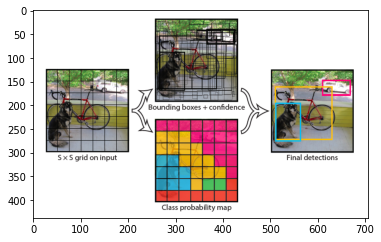

In [ ]:
image = mpimg.imread('yolo.png')
plt.imshow(image)

In [ ]:
# code based on:
# YAD2K https://github.com/allanzelener/YAD2K
# darkflow https://github.com/thtrieu/darkflow
# Darknet.keras https://github.com/sunshineatnoon/Darknet.keras
# https://github.com/xslittlegrass/CarND-Vehicle-Detection

# Box util methods

class Box:
    def __init__(self):
        self.x, self.y = float(), float()
        self.w, self.h = float(), float()
        self.c = float()
        self.prob = float()
        
def overlap(x1, w1, x2, w2):
    l1 = x1 - w1 / 2.
    l2 = x2 - w2 / 2.
    left = max(l1, l2)
    r1 = x1 + w1 / 2.
    r2 = x2 + w2 / 2.
    right = min(r1, r2)
    return right - left


def box_intersection(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection area of the 2 boxes
    """
    w = overlap(a.x, a.w, b.x, b.w)
    h = overlap(a.y, a.h, b.y, b.h)
    if w < 0 or h < 0:
        return 0
    area = w * h
    return area


def box_union(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Area under the union of the 2 boxes
    """
    i = box_intersection(a, b)
    u = a.w * a.h + b.w * b.h - i
    return u


def box_iou(a, b):
    """

    :param a: Box 1
    :param b: Box 2
    :return: Intersection over union, which is ratio of intersection area to union area of the 2 boxes
    """
    return box_intersection(a, b) / box_union(a, b)



def yolo_output_to_car_boxes(yolo_output, threshold=0.2, sqrt=1.8, C=20, B=2, S=7):

    # Position for class 'car' in the VOC dataset classes
    car_class_number = 6

    boxes = []
    SS = S*S  # number of grid cells
    prob_size = SS*C  # class probabilities
    conf_size = SS*B  # confidences for each grid cell

    probabilities = yolo_output[0:prob_size]
    confidence_scores = yolo_output[prob_size: (prob_size + conf_size)]
    cords = yolo_output[(prob_size + conf_size):]

    # Reshape the arrays so that its easier to loop over them
    probabilities = probabilities.reshape((SS, C))
    confs = confidence_scores.reshape((SS, B))
    cords = cords.reshape((SS, B, 4))

    for grid in range(SS):
        for b in range(B):
            bx = Box()

            bx.c = confs[grid, b]

            # bounding box xand y coordinates are offsets of a particular grid cell location,
            # so they are also bounded between 0 and 1.
            # convert them absolute locations relative to the image size
            bx.x = (cords[grid, b, 0] + grid % S) / S
            bx.y = (cords[grid, b, 1] + grid // S) / S


            bx.w = cords[grid, b, 2] ** sqrt
            bx.h = cords[grid, b, 3] ** sqrt

            # multiply confidence scores with class probabilities to get class sepcific confidence scores
            p = probabilities[grid, :] * bx.c

            # Check if the confidence score for class 'car' is greater than the threshold
            if p[car_class_number] >= threshold:
                bx.prob = p[car_class_number]
                boxes.append(bx)

    # combine boxes that are overlap

    # sort the boxes by confidence score, in the descending order
    boxes.sort(key=lambda b: b.prob, reverse=True)


    for i in range(len(boxes)):
        boxi = boxes[i]
        if boxi.prob == 0:
            continue

        for j in range(i + 1, len(boxes)):
            boxj = boxes[j]

            # If boxes have more than 40% overlap then retain the box with the highest confidence score
            if box_iou(boxi, boxj) >= 0.4:
                boxes[j].prob = 0

    boxes = [b for b in boxes if b.prob > 0]

    return boxes


def draw_boxes(boxes,im, crop_dim):
    imgcv1 = im.copy()
    [xmin, xmax] = crop_dim[0]
    [ymin, ymax] = crop_dim[1]
    
    height, width, _ = imgcv1.shape
    for b in boxes:
        w = xmax - xmin
        h = ymax - ymin

        left  = int ((b.x - b.w/2.) * w) + xmin
        right = int ((b.x + b.w/2.) * w) + xmin
        top   = int ((b.y - b.h/2.) * h) + ymin
        bot   = int ((b.y + b.h/2.) * h) + ymin

        if left  < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot>height - 1: 
            bot = height - 1
        
        thick = 5 #int((height + width // 150))
        
        cv2.rectangle(imgcv1, (left, top), (right, bot), (255,0,0), thick)

    return imgcv1

In [ ]:
# Load weights
from utils import load_weights

model = get_model()
load_weights(model,'yolo-tiny.weights')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


(1, 1470)
(49, 20)


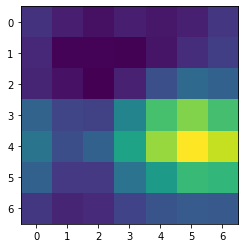

In [ ]:
test_image = mpimg.imread('test_images/test1.jpg')
pre_processed = preprocess(test_image)
batch = np.expand_dims(pre_processed, axis=0)
batch_output = model.predict(batch)
print(batch_output.shape)

S = 7
C = 20
B = 2
SS = S*S  # number of grid cells
prob_size = SS*C  # class probabilities
conf_size = SS*B  # confidences for each grid cell

probabilities = batch_output[0, 0:prob_size]
#confidence_scores = batch_output[prob_size: (prob_size + conf_size)]
#cords = batch_output[(prob_size + conf_size):]

probabilities = probabilities.reshape((SS, C))

print (probabilities.shape)

car_class_number = 6
plt.imshow(batch_output[0, 0:prob_size].reshape((S, S, C))[:,:,car_class_number])

#probabilities = np.argmax(probabilities.reshape((S, S, C))[:,:,[0,2,4,6,8,10,12,14,16,18]], 2)
#plt.imshow(probabilities)
#plt.show()

Text(0.5, 1.0, 'With Boxes')

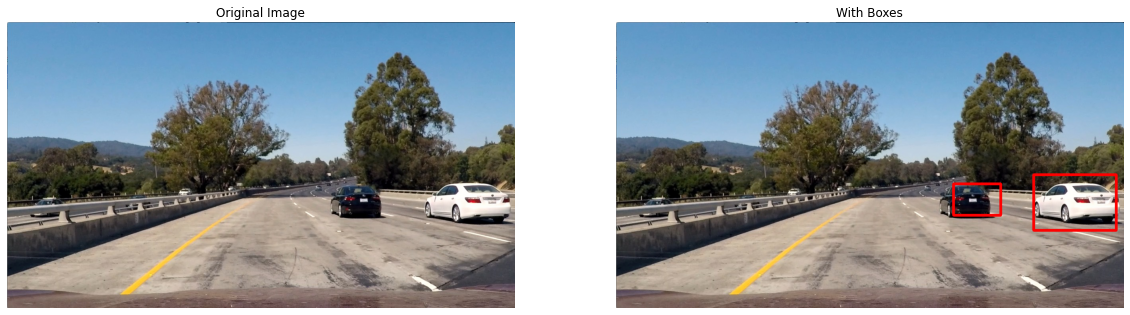

In [ ]:
boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.25)
final = draw_boxes(boxes, test_image, ((0,test_image.shape[1]),(0,test_image.shape[0])))

plt.rcParams['figure.figsize'] = (20, 11.2)
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.axis('off')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(final)
plt.axis('off')
plt.title("With Boxes")

In [ ]:
# Final pipeline
def pipeline(image):
    pre_processed = preprocess(image)
    batch = np.expand_dims(pre_processed, axis=0)
    batch_output = model.predict(batch)
    boxes = yolo_output_to_car_boxes(batch_output[0], threshold=0.20)
    final = draw_boxes(boxes, image, ((0,image.shape[1]),(0,image.shape[0])))
    return final

In [ ]:
!wget -q https://cdn.newsapi.com.au/image/v1/d8363432788e082e2b8dd38c6110edfa?width=650 --directory-prefix=test_images
!wget -q https://c.ndtvimg.com/2019-03/uqi6nml8_plane-crash-markham_625x300_14_March_19.jpg --directory-prefix=test_images
#!wget https://i.ytimg.com/vi/UdoVvypePbA/hqdefault.jpg --directory-prefix=test_images
#!wget https://i.ytimg.com/vi/ivNZ66vXzjw/hqdefault.jpg --directory-prefix=test_images
!rm='test_images/hqdefault.jpg'
!wget -q http://farm6.staticflickr.com/5053/5395659306_09de4e9c7d_z.jpg --directory-prefix=test_images
!wget -q https://secure.i.telegraph.co.uk/multimedia/archive/03590/carflip1_3590334b.jpg --directory-prefix=test_images

test_images/test2.jpg
test_images/carflip1_3590334b.jpg
test_images/5395659306_09de4e9c7d_z.jpg
test_images/test1.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test6.jpg
test_images/test5.jpg
test_images/uqi6nml8_plane-crash-markham_625x300_14_March_19.jpg


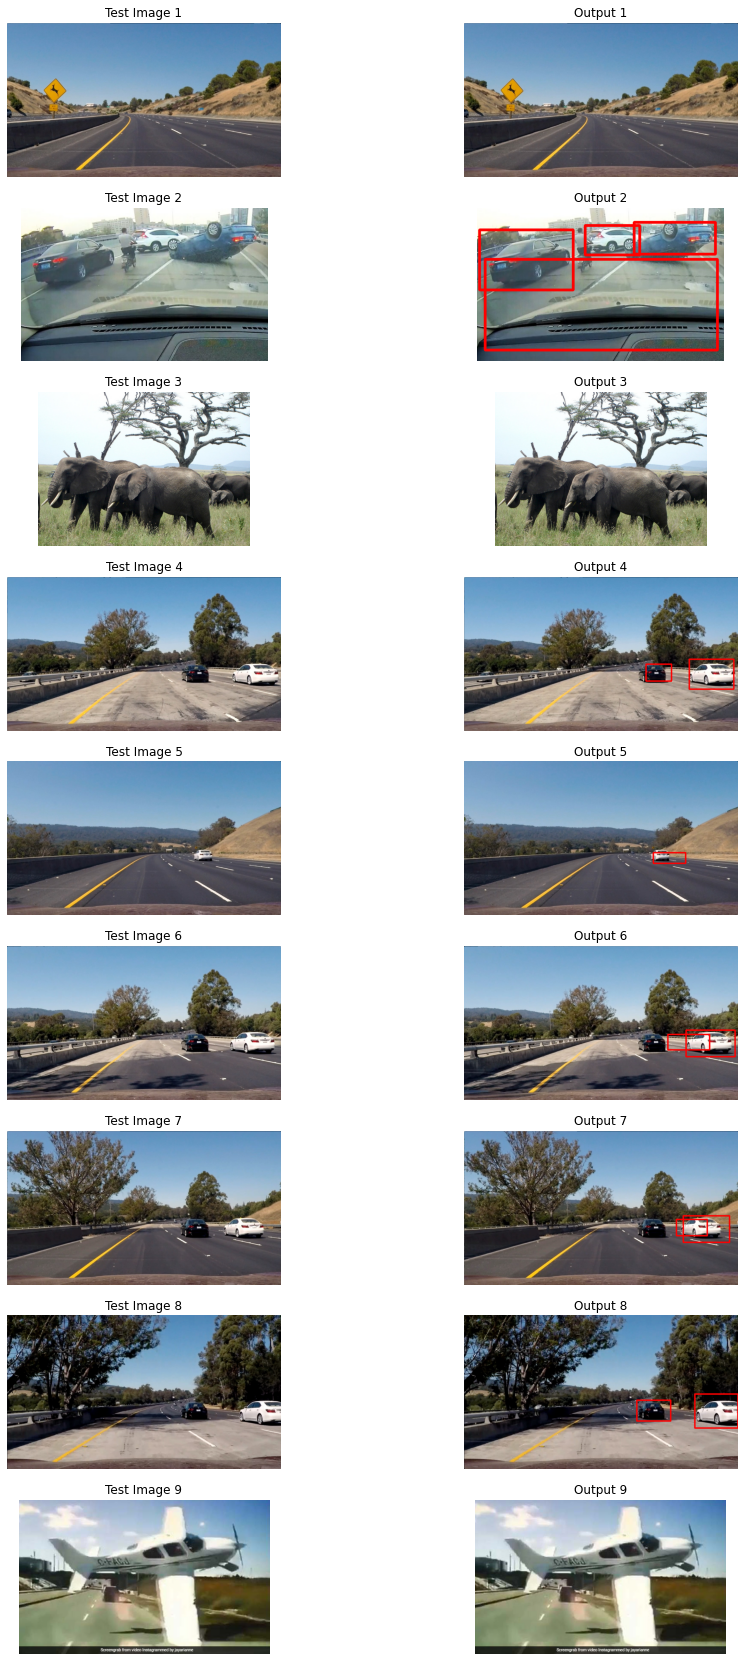

In [ ]:
filenames = glob.glob("test_images/*.jpg")
num_files = len(filenames)

plt.rcParams['figure.figsize'] = (15, 30)

for i in range(num_files):
    print (filenames[i])
    image = mpimg.imread(filenames[i])
    #image = cv2.flip(image, 0)
    final = pipeline(image)
    mpimg.imsave("output_images/test%d.jpg" % (i+1), final)
    
    plt.subplot(num_files,2,i*2+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Test Image %d" % (i+1))
    plt.subplot(num_files,2,i*2+2)
    plt.imshow(final)
    plt.axis('off')
    plt.title("Output %d" % (i+1))